In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis)
import torch
import torch.nn as nndata
import torch.optim as optim
from models import *
from data_generation_new import *
from utils import *
from training import *

In [2]:
J = 5
d = 5000
sigma1 = np.repeat(1,J)
theta1 = np.diag(np.repeat(0.8,J))
X_coef,Z_coef = generate_ma1(J = J, d = d, sigma = sigma1, theta = theta1)
print(X_coef.shape)

(5000, 5)


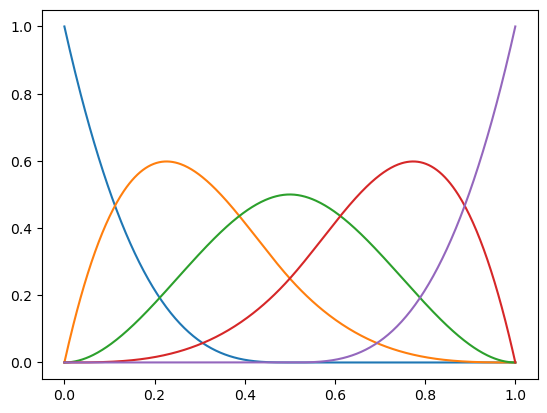

[0.26726124 0.33273756 0.3047247  0.33273756 0.26726124]


In [3]:
Bbasis = BSplineBasis(domain_range=(0, 1), n_basis=J)
Bbasis.plot()
plt.show()

G = Bbasis.gram_matrix()
norms = np.sqrt(np.diag(G))
print(norms)


So the bspline basis right now is not normalized, we times diag(1/n1,1/n2,....,1/nJ) to make it an normalized one.

$[b_1,b_2,\cdots,b_J]$ is the original bspline space.
$[\tilde{b}_1,\tilde{b}_2,\cdots,\tilde{b}_J] = diag(1/n1,1/n2,....,1/nJ) \times [b_1,b_2,\cdots,b_J]^T$ is the original bspline space.

In [4]:
bspline_norm_basis = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= np.diag(1/norms)  # X_coef: coefficient on 
)
# check if times diag(1/n1,1/n2,...,1/nJ), whether the norm would be all 1.
norm_values = np.sqrt(np.sum(bspline_norm_basis.coefficients @ G * bspline_norm_basis.coefficients, axis=1))

print(norm_values)

[1. 1. 1. 1. 1.]


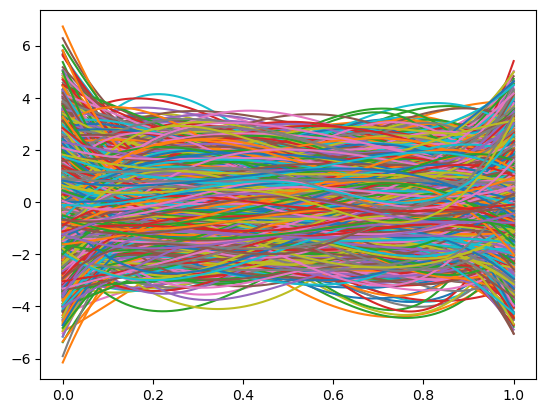

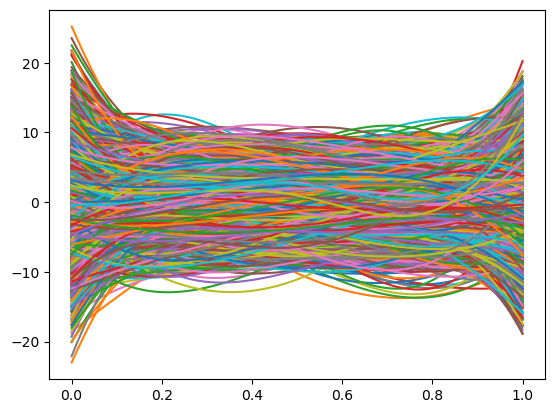

In [5]:
fd_basis1 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef   
)
fd_basis1.plot()
plt.show()

fd_basis2 = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef@ np.diag(1/norms)
)
fd_basis2.plot()
plt.show()

In [6]:
fpca = FPCA(n_components=5)
fpca.fit(fd_basis1)
scores = fpca.transform(fd_basis1)

fpca_tilde = FPCA(n_components=5)
fpca_tilde.fit(fd_basis2)
scores_tilde = fpca_tilde.transform(fd_basis2)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
print(sum(fpca.explained_variance_ratio_))
print("Explained variance by each PC:", fpca_tilde.explained_variance_ratio_)
print(sum(fpca_tilde.explained_variance_ratio_))

Explained variance by each PC: [0.48857551 0.27978102 0.137281   0.07864128 0.01572119]
1.0
Explained variance by each PC: [0.44771981 0.28847059 0.16815945 0.08099354 0.01465662]
1.0


In [7]:
E_coef = fpca_tilde.components_.coefficients 
E_coef_tilde2 = fpca.components_.coefficients 
scores.shape

(5000, 5)

In [8]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: Bbasis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [9]:
Y_np.shape

(5000,)

In [10]:
X = torch.tensor(scores_tilde.T, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([5, 5000])
torch.Size([1, 5000])


# Model adding covariates

In [ ]:
trunc_q = d-1# the trunctation number
m = d**(1/3) # the bandwidth
print(m)
q = 4

In [ ]:
trained_model, trained_weight_net, learned_weights = train_model(X, Y, Weight_QS, Model1_new, LR_cov_X, m, q, trunc_q)

In [ ]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_matrix, cov_matrix_w1, cov_matrix3 = LR_cov_X(X, trained_weight_net, trunc_q)
    cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


In [ ]:
cov_matrix

In [ ]:
import os
import pandas as pd
# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, f"cov_matrix_case1_FMA_{d}.csv")

# Convert matrices to DataFrames
df1 = pd.DataFrame(cov_matrix)
df2 = pd.DataFrame(cov_matrix_w1)
df3 = pd.DataFrame(cov_matrix3)

# Save matrices to CSV with an empty line between them
with open(csv_path, 'w', newline='') as f:
    df1.to_csv(f, index=False, header=False)
    f.write("\n")  # Write an empty line
    df2.to_csv(f, index=False, header=False)
    f.write("\n")  # Write another empty line
    df3.to_csv(f, index=False, header=False)

print(f"Saved matrices to {csv_path} with empty lines between them.")

# Compute true covariance matrix

In [ ]:
theoretical_cov_true = np.diag([3.24] * 5)

print(theoretical_cov_true)

In [ ]:
coefsE_on_btilde = E_coef_tilde2@ np.diag(norms)

In [ ]:
G_tilde = np.diag(1/norms) @ G @ np.diag(1/norms)

In [ ]:
hat_C = np.zeros((5, 5))

for l in range(5):
    for lp in range(5):
        sum1 = np.sum([coefsE_on_btilde[l, k] * G_tilde[:, k] for k in range(5)], axis=0)
        sum2 = np.sum([coefsE_on_btilde[lp, k] * G_tilde[:, k] for k in range(5)], axis=0)
        hat_C[l, lp] = np.sum([theoretical_cov_true[i, j] * sum1[i] * sum2[j] for i in range(5) for j in range(5)])
#print(np.round(hat_C,4))

In [ ]:
np.trace(hat_C)

In [ ]:
print(np.linalg.eigvals(hat_C))
sum(np.linalg.eigvals(hat_C))

In [ ]:
np.round(hat_C,4)

In [ ]:
cov_matrix

In [ ]:
fig = plot_matrices_2d([cov_matrix,cov_matrix_w1, cov_matrix3, hat_C], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [ ]:
filename = f"figures/matrix3d_compare{d}_truc{trunc_q}_bd{round(m)}_q{q}.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

In [ ]:
print("Sum of diagonal (cov_matrix):", torch.trace(cov_matrix))
print("Sum of diagonal (cov_matrix_w1):", torch.trace(cov_matrix_w1))
print("Sum of diagonal (cov_matrix3):", torch.trace(cov_matrix3))
print("Sum of diagonal (hat_C):", np.trace(hat_C))

In [ ]:
n = cov_matrix.shape[0]
delta = 1.0 / n

# Compute squared error via Riemann sum
L_T_h = np.sum((cov_matrix.detach().cpu().numpy() - hat_C) ** 2) * (delta ** 2)

print("L_{T,h} =", L_T_h)